# Compute a global mean, annual mean timeseries from the CESM Large Ensemble

In [1]:
%matplotlib inline
import os
import socket

from tqdm import tqdm_notebook

import dask
import dask.distributed
import ncar_jobqueue

import xarray as xr
import numpy as np
import esmlab

import intake
import intake_esm

import matplotlib.pyplot as plt

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/gpfs/u/home/mclong/codes/intake-esm/intake_esm/config.py:491: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loa

## Connect to the `intake-esm` data catalog

An input file `cesm1-le-collection.yml` specifies where to look for files and assembles a database for the CESM-LE. `intake-esm` configuration settings are stored by default in ~/.intake_esm/config.yaml or locally in .intake_esm/config.yaml.  Key things to specify are the `database_directory`, which is where the catalog data file (csv) is written to disk.

In [2]:
col = intake.open_esm_metadatastore(
    collection_input_file='cesm1-le-collection.yml',
    overwrite_existing=False)
col.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117556 entries, 0 to 117555
Data columns (total 18 columns):
resource            117556 non-null object
resource_type       117556 non-null object
direct_access       117556 non-null bool
experiment          117556 non-null object
case                117556 non-null object
component           117556 non-null object
stream              117556 non-null object
variable            117556 non-null object
date_range          117556 non-null object
ensemble            117556 non-null int64
file_fullpath       117556 non-null object
file_basename       117556 non-null object
file_dirname        117556 non-null object
ctrl_branch_year    0 non-null float64
year_offset         15145 non-null float64
sequence_order      117556 non-null int64
has_ocean_bgc       117556 non-null bool
grid                14293 non-null object
dtypes: bool(2), float64(2), int64(2), object(12)
memory usage: 15.5+ MB


## Compute grid weights for a global mean

### Load a dataset and read in the grid variables
To compute a properly-weighted spatial mean, we need a cell-volume array. We'll pick out the necessary grid variables from a single file. First, let's get an arbitrary POP history file from the catalog.

In [3]:
arbitrary_pop_file = col.search(experiment='20C', stream='pop.h').results.file_fullpath.tolist()[0]
ds = xr.open_dataset(arbitrary_pop_file, decode_times=False, decode_coords=False)
grid_vars = ['KMT', 'z_t', 'TAREA', 'dz']
ds = ds.drop([v for v in ds.variables if v not in grid_vars]).compute()
ds

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    dz       (z_t) float32 1000.0 1000.0 1000.0 ... 24992.674 24996.244 24998.11
Attributes:
    title:                     b.e11.B20TRC5CNBDRD.f09_g16.001
    history:                   Fri Aug 30 23:36:34 2013: /glade/apps/opt/nco/...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  Diagnostic and Prognostic Variables
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    start_time:                Th

### Compute a 3D topography mask
Now we'll compute the 3D volume field, masked appropriate by the topography.

First step is to create the land mask.

Text(0.5, 1.0, 'Pacific transect')

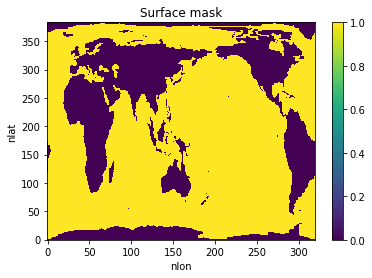

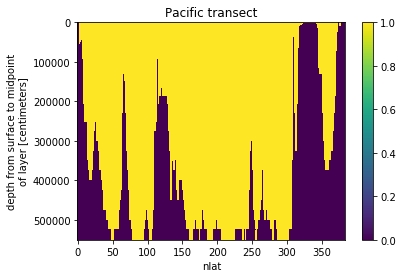

In [4]:
nk = len(ds.z_t)
nj = ds.KMT.shape[0]
ni = ds.KMT.shape[1]

# make 3D array of 0:km
k_vector_one_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'), coords={'z_t': ds.z_t})
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'), coords={'z_t': ds.z_t})
MASK = (k_vector_one_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = MASK.where(MASK <= ds.KMT - 1)
MASK = xr.where(MASK.notnull(), 1., 0.)

plt.figure()
MASK.isel(z_t=0).plot()
plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=200).plot(yincrease=False)
plt.title('Pacific transect')

### Compute the 3D volume field

Now we'll compute the masked volume field by multiplying `z_t` by `TAREA` by the mask created above.

Text(0.5, 1.0, 'Pacific transect')

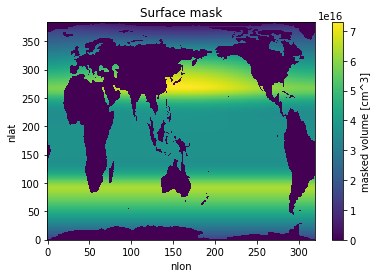

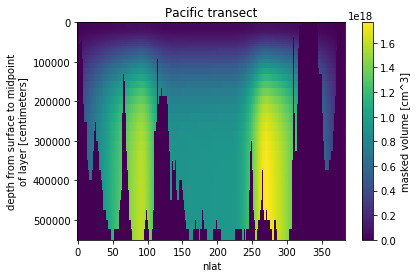

In [5]:
MASKED_VOL = ds.dz * ds.TAREA * MASK
MASKED_VOL.attrs['units'] = 'cm^3'
MASKED_VOL.attrs['long_name'] = 'masked volume'
plt.figure()
MASKED_VOL.isel(z_t=0).plot()
plt.title('Surface mask')

plt.figure()
MASKED_VOL.isel(nlon=200).plot(yincrease=False)
plt.title('Pacific transect')

## Compute global-mean, annual-means across the ensemble

### Find the ensemble members that have ocean biogeochemistry 
(several of the runs had corrupted BGC fields)

In [6]:
member_ids = col.search(experiment=['20C', 'RCP85'], has_ocean_bgc=True).results.ensemble.unique().tolist()
print(member_ids)

[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 101, 102, 103, 104, 105]


### Spin up a dask cluster

We are using `ncar_jobqueue.NCARCluster`; this just passes thru to `dask_jobqueue.PBSCluster` or `dask_jobqueue.SLURMCluster` depending on whether you are on Cheyenne or a DAV machine. 

**Note**: `dask_jobqueue.SLURMCluster` does not work on Cheyenne compute nodes, though the cluster jobs will start giving the appearance of functionality.

Default arguments to `ncar_jobqueue.NCARCluster` are set in `~/.config/dask/jobqueue.yaml`; you can over-ride these defaults by passing in arguments directly here.

In [7]:
cluster = ncar_jobqueue.NCARCluster()
client = dask.distributed.Client(cluster)
n_workers = 9 * 10
cluster.scale(n_workers)

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


After the worker jobs have started, it's possible to view the client attributes.

In [8]:
!qstat | grep dask-worker

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: ml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_ml'
4771382.chadmin1  dask-worker      mclong            00:00:24 R regular         
4771383.chadmin1  dask-worker      mclong            00:00:24 R regular         
4771384.chadmin1  dask-worker      mclong            00:00:24 R regular         
4771385.chadmin1  dask-worker      mclong            00:00:29 R regular         
4771386.chadmin1  dask-worker      mclong            00:00:23 R regular         
4771387.chadmin1  dask-worker      mclong            00:00:23 R regular         
4771388.chadmin1  dask-worker      mclong            00:00:23 R regular         
4771389.chadmin1  dask-worker      mclong            00:00:23 R regular         
4771390.chadmin1  dask-worker      mclong            00:00:23 R regular         
477

In [9]:
client

Client Scheduler: tcp://10.148.10.31:49317 Dashboard: http://10.148.10.31/proxy/57968/status,Cluster Workers: 90 Cores: 360 Memory: 1.09 TB


### Compute 

We'll loop over the ensemble and compute one at a time. In theory it should be possible to compute all at once, but in practice this doesn't seem to work.

In [ ]:
%%time
variable = ['O2']
dsets = []
for member_id in tqdm_notebook(member_ids):
    
    query = dict(ensemble=member_id, experiment=['20C', 'RCP85'], 
                 stream='pop.h', variable=variable, direct_access=True)

    col_subset = col.search(**query)

    # get a dataset
    ds = col_subset.to_xarray()

    # compute annual means
    dso = esmlab.climatology.compute_ann_mean(ds)

    # compute global average
    dso = esmlab.statistics.weighted_mean(dso, weights=MASKED_VOL, dim=['z_t', 'nlat', 'nlon'])

    # compute the dataset 
    dso = dso.compute()
    dsets.append(dso)


ensemble_dim = xr.DataArray(member_ids, dims='member_id', name='member_id')    
ds = xr.concat(dsets, dim=ensemble_dim)
ds

In [ ]:
cluster.close()

In [ ]:
for member_id in member_ids:
    ds.O2.sel(member_id=member_id).plot()

In [ ]:
set(ds.coords) - set(ds.dims)